In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_excel("./EE325_Final Marks.xlsx")
df.tail(5)

FileNotFoundError: ignored

In [ ]:
# do NOT run this cell
sur_df = pd.read_csv('./Study_Groups.tsv', sep='\t')
sur_df.drop(columns=['Timestamp'], inplace=True)
sur_df.columns = ['email', 'friends']

name_dict = {}
email_dict = {}
for i in range(df.shape[0]):
    email_dict[df['eMail'][i]] = i
    name_dict[df['Student Name'][i]] = i

name_dict['I always study alone'] = -1

adj_list = {}
for i in range(sur_df.shape[0]):
    adj_list[email_dict[sur_df['email'][i]]] = sur_df['friends'][i].split(', ')

for k in adj_list.keys():
    for i in range(len(adj_list[k])):
        adj_list[k][i] = name_dict[adj_list[k][i]]

'''import pickle

with open('survey_adj_list.pickle', 'wb') as handle:
    pickle.dump(adj_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

handle.close()'''

In [ ]:
import pickle

with open('survey_adj_list.pickle', 'rb') as handle:
    adj_list = pickle.load(handle)

handle.close()

keys = adj_list.keys()
for k in keys:
    if k in adj_list[k]:
        adj_list[k].remove(k)
    if -1 in adj_list[k]:
        adj_list[k].remove(-1)

invalid = []
for k in keys:
    if len(adj_list[k]) == 0:
        invalid.append(k)

adj_copy = adj_list.copy()
for k in keys:
    if k in invalid:
        del adj_copy[k]


import pickle

with open('survey_adj_list_clean1.pickle', 'wb') as handle:
    pickle.dump(adj_copy, handle, protocol=pickle.HIGHEST_PROTOCOL)

handle.close()

# Start from here

In [ ]:
import pickle

with open('survey_adj_list_clean1.pickle', 'rb') as handle:
    adj_list = pickle.load(handle)

handle.close()

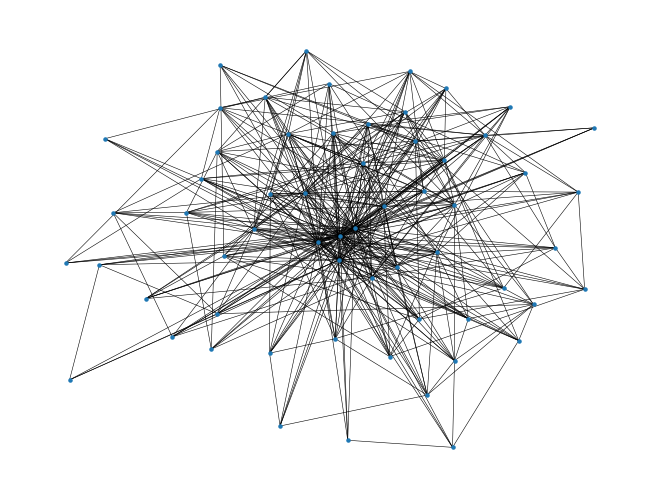

In [ ]:
sur_net = nx.from_dict_of_lists(adj_list)
nx.draw(sur_net, node_size = 5, width = 0.4)
plt.show()

In [ ]:
marks = [np.mean(df.iloc[:,[4,5,6,7,8]], axis = 1)[n] for n in sur_net.nodes()]

In [ ]:
from pyvis.network import Network
net = Network('500px', '800px',notebook=True)
net.repulsion(node_distance=400, spring_length=200)

net.add_nodes(list(sur_net.nodes()), value = marks)
for i,j in sur_net.edges():
    net.add_edge(i,j)
    
net.show('sur.html')


In [ ]:
def degree_dist(graph, log= False, w = None):
    degrees = [graph.degree(n, weight = w) for n in graph.nodes()]
    degrees = np.asarray(degrees)
    if log: dist =  np.log(degrees)
    else: dist =  degrees
    return dist

In [ ]:
x = nx.to_numpy_array(sur_net)
d = np.sum(x, axis=1).reshape(-1,1)
d*np.eye(60)

array([[18.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 16.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 19., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  6.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  4.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  5.]])

In [ ]:
def datacon(g1, g2, e = 1e-6):
    A1 = nx.to_numpy_array(g1)
    A2 = nx.to_numpy_array(g2)
    d1 = np.sum(A1, axis=1).reshape(-1,1)
    d2 = np.sum(A2, axis=1).reshape(-1,1)
    D1 = np.eye(A1.shape[0])*d1
    D2 = np.eye(A2.shape[0])*d2
    S1 = np.linalg.inv(np.eye(A1.shape[0]) + D1*(e**2) + A1*(-e))
    S2 = np.linalg.inv(np.eye(A2.shape[0]) + D2*(e**2) + A2*(-e))
    d = np.sqrt(np.sum(np.square(np.sqrt(S1) - np.sqrt(S2))))
    return d
    

In [ ]:
barabasi = nx.barabasi_albert_graph(n = 60, m= 2)

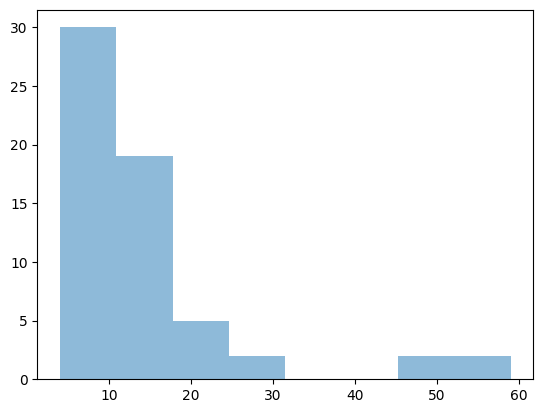

In [ ]:
dist_sur = degree_dist(sur_net, log=False)
plt.hist(dist_sur, bins=8, alpha = 0.5)
plt.show()

In [ ]:
degrees = degree_dist(sur_net)

In [ ]:
marks = np.asarray([df.iloc[:,17][n] for n in sur_net.nodes()])
np.corrcoef(x = marks, y = degrees)

array([[1.        , 0.23638547],
       [0.23638547, 1.        ]])

In [ ]:

def Monte_Carlo_ICM(g, p, seed, runs):
    estimate = []
    node_list = list(g.nodes())
    adj_list = nx.to_dict_of_lists(g)
    
    for t in range(runs):
        info_list = dict(zip(node_list, np.zeros((len(node_list),)) == 1))
        nx.set_node_attributes(g, info_list, "info")
        for s in seed:
            g.nodes[s]["info"] = True
        seed_proxy = seed.copy()

        for n in seed_proxy:
            for nei in adj_list[n]:
                if not(g.nodes[nei]["info"]):
                    toss = random.random()
                    if p > toss:
                        g.nodes[nei]["info"] = True
                        seed_proxy.append(nei)
        estimate.append(len(seed_proxy))
    return np.array(estimate, dtype=np.int32)

In [ ]:
icm_sur = Monte_Carlo_ICM(sur_net, 0.1, [51], 10000)
round(icm_sur.mean())

20

# Correlation Network

In [ ]:
X = df.iloc[:60,4:9].to_numpy()
corr = np.corrcoef(X)
corr = 0.5 + 0.5*corr
adj = corr - np.eye(60)
#adj = adj >= 0.8
#marks_net = nx.from_numpy_matrix(adj)

In [ ]:
datacon(sur_net, marks_net, e = 1e-12)

2.922327839273127e-05

In [ ]:
distances = []
for t in np.linspace(0.75,0.85, 22):
    adj_ = adj >= t
    marks_net = nx.from_numpy_matrix(adj_)
    d = datacon(marks_net, sur_net, 0.01)
    distances.append(d)
    print(t,'\t', d)

0.75 	 3.200584082630727
0.7547619047619047 	 3.2047656855605946
0.7595238095238095 	 3.1946387071373015
0.7642857142857142 	 3.168713355875948
0.7690476190476191 	 3.1581434298685687
0.7738095238095238 	 3.145503219312031
0.7785714285714286 	 3.137962800519673
0.7833333333333333 	 3.1327869574178697
0.7880952380952381 	 3.1349939541514478
0.7928571428571428 	 3.1268085733526596
0.7976190476190476 	 3.125936113608742
0.8023809523809524 	 3.1270264874133686
0.8071428571428572 	 3.121685857587881
0.8119047619047619 	 3.1229892537791417
0.8166666666666667 	 3.1267223221476605
0.8214285714285714 	 3.140579746617672
0.8261904761904761 	 3.136809247961632
0.8309523809523809 	 3.1388664036324894
0.8357142857142856 	 3.138502412244634
0.8404761904761905 	 3.1377749501932093
0.8452380952380952 	 3.1371071534734787
0.85 	 3.1467031999174755


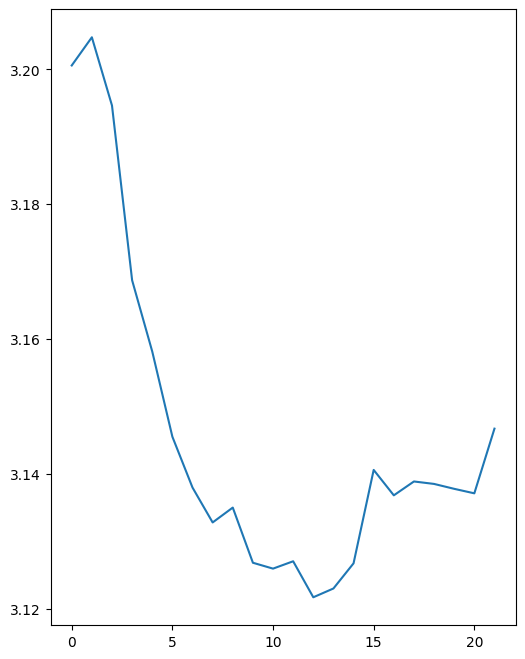

In [ ]:
fig = plt.figure()
fig.set_figwidth(6)
fig.set_figheight(8)
plt.plot(distances)
plt.show()

In [ ]:
icm_marks = Monte_Carlo_ICM(marks_net, 0.1, [51], 10000)
round(icm_marks.mean())

26

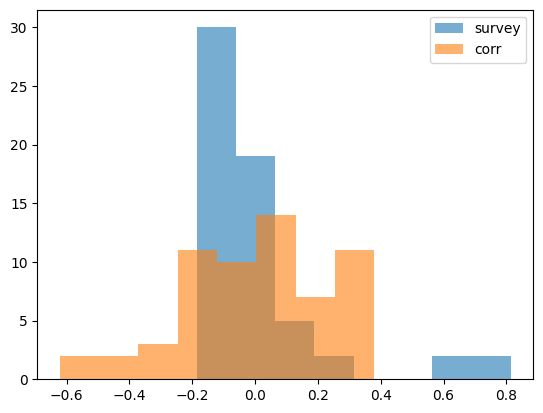

In [ ]:
from sklearn.preprocessing import MinMaxScaler
marks_dist = degree_dist(marks_net, w='weight')
dist_sur = degree_dist(sur_net)
scale = MinMaxScaler()
marks_dist = scale.fit_transform(marks_dist.reshape(-1,1))
marks_dist -= np.mean(marks_dist)
scale = MinMaxScaler()
dist_sur = scale.fit_transform(dist_sur.reshape(-1,1))
dist_sur -= np.mean(dist_sur)
plt.hist(dist_sur, bins=8, alpha = 0.6)
plt.hist(marks_dist, bins=8, alpha = 0.6)
plt.legend(["survey", "corr"])
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
marks_dist = degree_dist(marks_net)
dist_sur = degree_dist(sur_net)
#scale = MinMaxScaler()
#marks_dist = scale.fit_transform(marks_dist.reshape(-1,1))
#marks_dist -= np.mean(marks_dist)
#scale = MinMaxScaler()
#dist_sur = scale.fit_transform(dist_sur.reshape(-1,1))
#dist_sur -= np.mean(dist_sur)
plt.hist(dist_sur, bins=8, alpha = 0.6)
plt.hist(marks_dist, bins=8, alpha = 0.6)
plt.legend(["survey", "corr"])
plt.show()

In [ ]:
marks_dist = degree_dist(marks_net)
dist_sur = degree_dist(sur_net)

In [ ]:
sur_eig = nx.eigenvector_centrality(sur_net)
marks_eig = nx.eigenvector_centrality(marks_net, weight = 'weight')
eig_vec = np.asarray(list(sur_eig.values()))
marks_vec = np.asarray(list(marks_eig.values()))

In [ ]:
np.corrcoef(x = dist_sur, y = marks_vec)

array([[1.        , 0.24467232],
       [0.24467232, 1.        ]])

In [ ]:
np.corrcoef(x = marks_dist, y = dist_sur)

array([[1.        , 0.23518802],
       [0.23518802, 1.        ]])

In [ ]:
adj = corr - np.eye(60)
adj = adj >= 0.8

In [ ]:
def jaccard(x1, x2): # where x1 and x2 are two lists of nodes
    x1, x2 = set(x1), set(x2)
    jcc = len(x1.intersection(x2))/len(x1.union(x2))
    return jcc

In [ ]:
for t in np.linspace(0.1, 0.9, num=1000):
    adj = corr - np.eye(60)
    adj = adj >= t
    print(jaccard(adj, sur_adj))

0.12205965576411407
1.6324420250566258
1.2102779068543341
0.9871936759074389
0.7607425152206222
0.5313370920769556
0.42444427132894624


In [ ]:
G = nx.from_numpy_matrix(adj)

In [ ]:
names = list(df["Student Name"])
name_dict = dict()
for i in range(60):
    name_dict[i] = names[i]

In [ ]:
pos = nx.spring_layout(sur_net, k=0.1, iterations=10)
nx.draw(sur_net, pos, node_size = 5, width = 0.4)
plt.show()

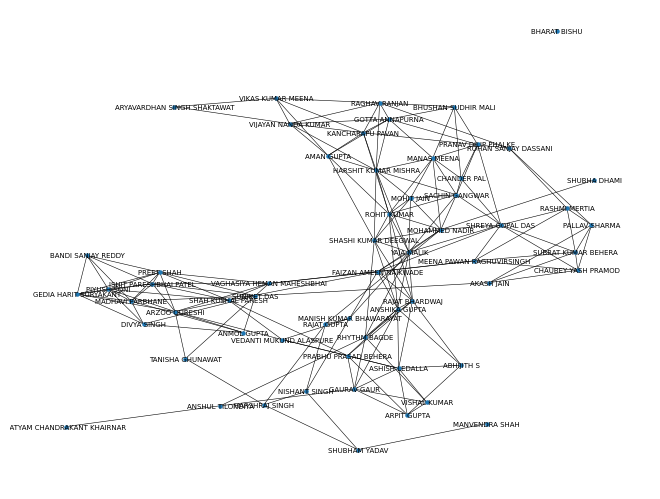

In [ ]:
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw(G,pos, node_size = 5, width = 0.4,labels=name_dict, with_labels = True, font_size = 5)
plt.show()

In [ ]:
import random
def ICM(G,initial_active_nodes,prob,iters):
    total_active_nodes = 0          # store total number of active nodes in each iterations
    for t in range(iters):
        active_nodes = initial_active_nodes.copy()   
        nodes_visited = []          # once a active node is considered, it should not consider it again
        
        # loop will continue if size of active_nodes is changing 
        while 1:
            new_active_nodes=[]
            # finding inactive node v, neighbour of active node u, such that rand probability <= diffusion probablity and is not visited 
            for u in active_nodes:
                if u not in nodes_visited:      # once a active node is considered, it should not consider it again
                    nodes_visited.append(u)
                    for v in nx.neighbors(G,u):
                        if v not in nodes_visited :     # active node should not be considered 
                            rand_p= random.random()
                            if rand_p <= prob:
                                new_active_nodes.append(v)

            if len(new_active_nodes)==0:            # if no change in new active nodes, break
                break
            active_nodes = new_active_nodes.copy()
        total_active_nodes+=len(nodes_visited)       # total active nodes after each iter
    return total_active_nodes/iters


def main1():
    nodes = 1000
    G = nx.barabasi_albert_graph(nodes,2)
    active_nodes = []
    while len(active_nodes)<50:
        x = random.randint(0,nodes-1)
        if x not in active_nodes:
            active_nodes.append(x)
    prob = random.uniform(0.05,0.15)
    iters = 10000
    print("Avg number of Active Nodes for ICM (prob = {}) after {} iters = {}".format(prob,iters,ICM(G,active_nodes,prob,iters)))
    prob = random.uniform(0.05,0.15)
    iters = 10000
    print("Avg number of Active Nodes for ICM (prob = {}) after {} iters = {}".format(prob,iters,ICM(G,active_nodes,prob,iters)))
    prob = random.uniform(0.05,0.15)
    iters = 10000
    print("Avg number of Active Nodes for ICM (prob = {}) after {} iters = {}".format(prob,iters,ICM(G,active_nodes,prob,iters)))
    return 